In [4]:
from pyspark import SparkConf, SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext()
spark = SparkSession(sc)

# Problem 1:  
Remove the header of the attached Samll_Car_Data.csv file and then import it into Spark. Randomly select 10% of you data for testing and use remaining data for training. Look initially at horsepower and displacement. Treat displacement as a feature and horsepower as the target variable. Use MLlib linear regression to identify the model for the relationship. Use test data to illustrate accuracy of your ability to predict the relationship. Create a diagram using D3 which presents the model (straight line), original test data and predictions of your analysis. Please label your axes and use different colors for original data and predicted data.

# Load The Data

In [5]:
car_df = spark.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('Small_Car_Data2.csv')
car_df.take(1)

[Row(Acceleration=12.0, Cylinders=8, Displacement=307, Horsepower=130, Manufacturer='chevrolet    ', Model='chevrolet chevelle malibu        ', Model_Year=70, MPG=18.0, Origin='USA    ', Weight=3504)]

In [6]:
car_df.show()

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|
|        11.0|        8|         318|       150|plymouth     |plymouth satellit...|        70|18.0|USA    |  3436|
|        12.0|        8|         304|       150|amc          |amc rebel sst    ...|        70|16.0|USA    |  3433|
|        10.5|        8|         302|       140|ford         |ford torino      ...|        70|17.0|USA    |  3449|
|        10.0|        8|         429|       198|ford         |ford galaxie 500 .

In [7]:
car_df.describe()

DataFrame[summary: string, Acceleration: string, Cylinders: string, Displacement: string, Horsepower: string, Manufacturer: string, Model: string, Model_Year: string, MPG: string, Origin: string, Weight: string]

# Data Exploration

In [8]:
# Print Schema in the tree format
car_df.cache()
car_df.printSchema()

root
 |-- Acceleration: double (nullable = true)
 |-- Cylinders: integer (nullable = true)
 |-- Displacement: integer (nullable = true)
 |-- Horsepower: integer (nullable = true)
 |-- Manufacturer: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Model_Year: integer (nullable = true)
 |-- MPG: double (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Weight: integer (nullable = true)



In [9]:
# descriptive data
car_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Acceleration,100,15.028000000000004,3.348452982160175,8.0,24.6
Cylinders,100,5.62,1.7909988184465022,4,8
Displacement,100,207.6,111.77448435817251,85,455
Horsepower,100,111.83,45.345153316456326,46,225
Manufacturer,100,None,None,amc,volvo
Model,100,None,None,amc ambassador dpl,volvo 245
Model_Year,100,75.76,4.893037725362245,70,82
MPG,100,23.315,7.966994731421944,9.0,44.0
Origin,100,None,None,France,USA


In [10]:
# find the correlation between independent features and target variable
import six
for i in car_df.columns:
    if not( isinstance(car_df.select(i).take(1)[0][0], six.string_types)):
        print( "Correlation to Horsepower for ", i, car_df.stat.corr('Horsepower',i))

Correlation to Horsepower for  Acceleration -0.6941178810791645
Correlation to Horsepower for  Cylinders 0.8618725271539766
Correlation to Horsepower for  Displacement 0.9135598437999649
Correlation to Horsepower for  Horsepower 1.0
Correlation to Horsepower for  Model_Year -0.6084983749782751
Correlation to Horsepower for  MPG -0.7973574552873728
Correlation to Horsepower for  Weight 0.8722465678203942


In [11]:
# Prepare Machine learning with feature ("Displacement") & label ("Horepower")
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['Displacement'], outputCol = 'features')
vcar_df = vectorAssembler.transform(car_df)
vcar_df = vcar_df.select(['features','Displacement', 'Horsepower'])
vcar_df.show()

+--------+------------+----------+
|features|Displacement|Horsepower|
+--------+------------+----------+
| [307.0]|         307|       130|
| [350.0]|         350|       165|
| [318.0]|         318|       150|
| [304.0]|         304|       150|
| [302.0]|         302|       140|
| [429.0]|         429|       198|
| [454.0]|         454|       220|
| [440.0]|         440|       215|
| [455.0]|         455|       225|
| [390.0]|         390|       190|
| [133.0]|         133|       115|
| [350.0]|         350|       165|
| [351.0]|         351|       153|
| [383.0]|         383|       175|
| [360.0]|         360|       175|
| [383.0]|         383|       170|
| [340.0]|         340|       160|
| [302.0]|         302|       140|
| [400.0]|         400|       150|
| [455.0]|         455|       225|
+--------+------------+----------+
only showing top 20 rows



# Split train & test data

In [12]:
train_df,test_df = vcar_df.randomSplit([0.9, 0.1],seed=0)

In [13]:
test_df.count(), train_df.count()

(10, 90)

# Linear Regression
## training data

In [15]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='Horsepower', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.3728492604002122]
Intercept: 34.227574832818114


In [16]:
# Summarize the model
trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

# R^2 at 0.838 indicates that in our linear regression model, there are about 83.8% of the variability in “Horsepower” can be explained using the model. 

RMSE: 18.609832
r2: 0.838405


In [17]:
train_df.describe().show()

+-------+------------------+------------------+
|summary|      Displacement|        Horsepower|
+-------+------------------+------------------+
|  count|                90|                90|
|   mean|207.84444444444443|111.72222222222223|
| stddev|113.53541358240759|46.553829608164534|
|    min|                85|                46|
|    max|               455|               225|
+-------+------------------+------------------+



## test data

In [18]:
lr_predictions = lr_model.transform(test_df)
lr_predictions.select("prediction","Horsepower","features").show(5)
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Horsepower",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

+-----------------+----------+--------+
|       prediction|Horsepower|features|
+-----------------+----------+--------+
|74.12244569564082|        75| [107.0]|
|75.98669199764188|        88| [112.0]|
| 79.3423353412438|       113| [121.0]|
|84.56222498684676|        84| [135.0]|
|90.52781315325015|        91| [151.0]|
+-----------------+----------+--------+
only showing top 5 rows

R Squared (R2) on test data = 0.764507


In [19]:
test_result = lr_model.evaluate(test_df)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 15.8483


In [20]:
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()

numIterations: 3
objectiveHistory: [0.5, 0.41039789119649395, 0.08604708341278823]
+--------------------+
|           residuals|
+--------------------+
| -13.919761966836148|
|   4.080238033163852|
|   2.215991731162788|
| -15.156857529237428|
| -1.1568575292374277|
| -1.1568575292374277|
| -1.1568575292374277|
|-0.15685752923742768|
|-0.15685752923742768|
| -24.393953091638707|
| -18.393953091638707|
|  0.6060469083612929|
|   4.606046908361293|
|  17.606046908361293|
| -10.766802352038908|
| -0.7668023520389085|
|   8.233197647961092|
|  11.114649866760459|
|  21.996102085559812|
| -10.376747174840403|
+--------------------+
only showing top 20 rows



# Make Predictions

In [21]:
predictions = lr_model.transform(test_df)
predictions.select("prediction","Horsepower",
                   'Displacement',"features").show()

+------------------+----------+------------+--------+
|        prediction|Horsepower|Displacement|features|
+------------------+----------+------------+--------+
| 74.12244569564082|        75|         107| [107.0]|
| 75.98669199764188|        88|         112| [112.0]|
|  79.3423353412438|       113|         121| [121.0]|
| 84.56222498684676|        84|         135| [135.0]|
| 90.52781315325015|        91|         151| [151.0]|
|101.71329096525653|       110|         181| [181.0]|
|120.72860324566736|        90|         232| [232.0]|
|147.57374999448263|       150|         304| [304.0]|
| 165.0976652332926|       152|         351| [351.0]|
| 168.4533085768945|       175|         360| [360.0]|
+------------------+----------+------------+--------+



# Plot the linear regression

In [22]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import polyfit

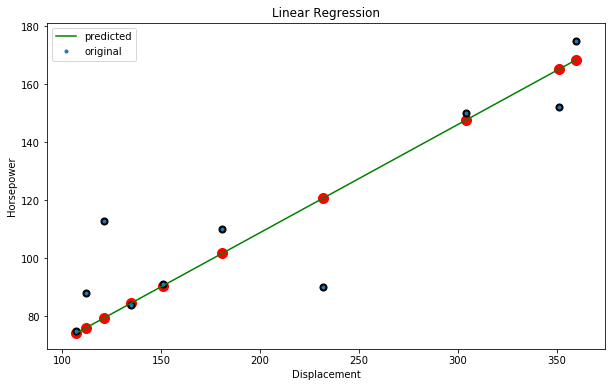

In [23]:
x1 = predictions.toPandas()['Displacement'].values.tolist()
y1 = predictions.toPandas()['prediction'].values.tolist()
y2 = predictions.toPandas()['Horsepower'].values.tolist()

plt.figure(1, figsize=(10,6))
plt.scatter(x1, y1, color='red', s=100)
plt.scatter(x1, y2, color='black', s=50)
plt.xlabel('Displacement')
plt.ylabel('Horsepower')
plt.title('Linear Regression')

p1 = polyfit(x1, y1, 1)


plt.plot(x1, np.polyval(p1,x1), 'g-',label='predicted')
plt.plot(x1,y2,'.',label='original')
plt.legend(loc='upper left')
plt.show()

# Problem 2:  
Treat: cylinders, displacement, manufacturer, model year, origin and weight as features and use linear regression to predict two target variable: horsepower and acceleration. Please note that some of those are categorical variables. Use test data to assess quality of prediction for both target variables. Which of two target variables is easier to predict, in the sense that predicted values differ less from the original values

In [28]:
# Convert categorical data: "Origin" and "Manufacturer"
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

conda install prompt_toolkit==2.0.10

In [ ]:
car_df.describe()

## Dealing with Categorical data by using StringIndexer

In [44]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(car_df) 
            for column in list(set(car_df.columns)-set(['Acceleration','Cylinders','Displacement',
                                                    'Horsepower','Model','Model_Year','MPG','Weight'])) ]

pipeline = Pipeline(stages=indexers)
car_df2 = pipeline.fit(car_df).transform(car_df)

car_df2.show()

+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+------------------+------------+
|Acceleration|Cylinders|Displacement|Horsepower| Manufacturer|               Model|Model_Year| MPG| Origin|Weight|Manufacturer_index|Origin_index|
+------------+---------+------------+----------+-------------+--------------------+----------+----+-------+------+------------------+------------+
|        12.0|        8|         307|       130|chevrolet    |chevrolet chevell...|        70|18.0|USA    |  3504|               1.0|         0.0|
|        11.5|        8|         350|       165|buick        |buick skylark 320...|        70|15.0|USA    |  3693|               9.0|         0.0|
|        11.0|        8|         318|       150|plymouth     |plymouth satellit...|        70|18.0|USA    |  3436|               4.0|         0.0|
|        12.0|        8|         304|       150|amc          |amc rebel sst    ...|        70|16.0|USA    |  3433|    

In [45]:
car_df2.describe()

DataFrame[summary: string, Acceleration: string, Cylinders: string, Displacement: string, Horsepower: string, Manufacturer: string, Model: string, Model_Year: string, MPG: string, Origin: string, Weight: string, Manufacturer_index: string, Origin_index: string]

In [52]:
# Prepare Machine learning with features & label
# Feature assembler as a vector

# Target Variable: 'Horsepower'
vcar_df2_1 = VectorAssembler(inputCols=["Origin_index","Manufacturer_index","Cylinders", 
                                        "Displacement","Model_Year","Weight"],
                        outputCol="features").transform(car_df2)
vcar_df2_1 = vcar_df2_1.select(['features', 'Horsepower',''])
vcar_df2_1.show()


# Target Variable: 'Acceleration'
vcar_df2_2 = VectorAssembler(inputCols=["Origin_index","Manufacturer_index","Cylinders", 
                                        "Displacement","Model_Year","Weight"],
                        outputCol="features").transform(car_df2)
vcar_df2_2 = vcar_df2_2.select(['features', 'Acceleration'])
vcar_df2_2.show()

+--------------------+----------+
|            features|Horsepower|
+--------------------+----------+
|[0.0,1.0,8.0,307....|       130|
|[0.0,9.0,8.0,350....|       165|
|[0.0,4.0,8.0,318....|       150|
|[0.0,2.0,8.0,304....|       150|
|[0.0,0.0,8.0,302....|       140|
|[0.0,0.0,8.0,429....|       198|
|[0.0,1.0,8.0,454....|       220|
|[0.0,4.0,8.0,440....|       215|
|[0.0,8.0,8.0,455....|       225|
|[0.0,2.0,8.0,390....|       190|
|[3.0,17.0,4.0,133...|       115|
|[0.0,1.0,8.0,350....|       165|
|[0.0,0.0,8.0,351....|       153|
|[0.0,4.0,8.0,383....|       175|
|[0.0,2.0,8.0,360....|       175|
|[0.0,3.0,8.0,383....|       170|
|[0.0,4.0,8.0,340....|       160|
|[0.0,0.0,8.0,302....|       140|
|[0.0,1.0,8.0,400....|       150|
|[0.0,9.0,8.0,455....|       225|
+--------------------+----------+
only showing top 20 rows

+--------------------+------------+
|            features|Acceleration|
+--------------------+------------+
|[0.0,1.0,8.0,307....|        12.0|
|[0.0,9.0,8.0,

# Split train & test data

In [57]:
train_df2_1,test_df2_1 = vcar_df2_1.randomSplit([0.9, 0.1],seed=0)
print(test_df2_1.count(), train_df2_1.count())

train_df2_2,test_df2_2 = vcar_df2_2.randomSplit([0.9, 0.1],seed=0)
print(test_df2_2.count(), train_df2_2.count())

10 90
10 90


# Linear Regression
## training data

In [59]:
# Building the linear model with multiple features 

# Target Variable: 'Horsepower'
lr2_1 = LinearRegression(labelCol="Horsepower", featuresCol="features")
 
lr_model2_1 = lr2_1.fit(train_df2_1)

print(" 'Horsepower'Coefficients: " + str(lr_model2_1.coefficients))
print(" 'Horsepower' Intercept: " + str(lr_model2_1.intercept))

# Target Variable: 'Acceleration'

lr2_2 = LinearRegression(labelCol="Acceleration", featuresCol="features")
 
lr_model2_2 = lr2_2.fit(train_df2_2)

print("'Acceleration' Coefficients: " + str(lr_model2_2.coefficients))
print("'Acceleration' Intercept: " + str(lr_model2_2.intercept))

#"Origin_index","Manufacturer_index","Cylinders","Displacement","Model_Year","Weight"

 'Horsepower'Coefficients: [0.723678229197114,0.5993980730081919,-6.833005041865537,0.3376684001794473,-1.2207906782870934,0.018700623532089535]
 'Horsepower' Intercept: 111.86265583290029
'Acceleration' Coefficients: [-0.6436220953236311,0.019961593392296913,-0.44548247366027477,-0.03520173693120291,-0.0264355656527343,0.002903173669075452]
'Acceleration' Intercept: 18.341777991830014


In [61]:
# Summarize the model
# Target Variable: 'Horsepower'
trainingSummary2_1 = lr_model2_1.summary
print("RMSE: %f" % trainingSummary2_1.rootMeanSquaredError)
print("r2: %f" % trainingSummary2_1.r2)
train_df2_1.describe().show()

# Target Variable: 'Acceleration'
trainingSummary2_2 = lr_model2_2.summary
print("RMSE: %f" % trainingSummary2_2.rootMeanSquaredError)
print("r2: %f" % trainingSummary2_2.r2)
train_df2_2.describe().show()


RMSE: 16.192182
r2: 0.873034
+-------+------------------+
|summary|        Horsepower|
+-------+------------------+
|  count|                90|
|   mean|111.72222222222223|
| stddev|45.697104320961614|
|    min|                46|
|    max|               225|
+-------+------------------+

RMSE: 2.038331
r2: 0.598535
+-------+------------------+
|summary|      Acceleration|
+-------+------------------+
|  count|                90|
|   mean|15.040000000000004|
| stddev|3.2350190593884833|
|    min|               8.0|
|    max|              22.2|
+-------+------------------+



- Use test data to assess quality of prediction for both target variables. Which of two target variables is easier to predict, in the sense that predicted values differ less from the original values ↓

# Test Data

In [64]:
# Target Variable: 'Horsepower'
lr_predictions2_1 = lr_model2_1.transform(test_df2_1)
lr_predictions2_1.select("prediction","Horsepower","features").show(5)

lr_evaluator2_1 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Horsepower",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator2_1.evaluate(lr_predictions2_1))

# Target Variable: 'Acceleration'
lr_predictions2_2 = lr_model2_2.transform(test_df2_2)
lr_predictions2_2.select("prediction","Acceleration","features").show(5)

lr_evaluator2_2 = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Acceleration",metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator2_2.evaluate(lr_predictions2_2))


+------------------+----------+--------------------+
|        prediction|Horsepower|            features|
+------------------+----------+--------------------+
| 76.07343374754245|        82|[0.0,1.0,4.0,119....|
| 159.0328905065947|       145|[0.0,1.0,8.0,350....|
| 139.7924984041112|       150|[0.0,2.0,8.0,304....|
|  176.630140832425|       190|[0.0,2.0,8.0,390....|
|62.017399362461475|        63|[0.0,4.0,4.0,105....|
+------------------+----------+--------------------+
only showing top 5 rows

R Squared (R2) on test data = 0.942287
+------------------+------------+--------------------+
|        prediction|Acceleration|            features|
+------------------+------------+--------------------+
| 18.11971899212908|        19.4|[0.0,1.0,4.0,119....|
|12.240538108512245|        12.0|[0.0,1.0,8.0,350....|
|12.232618972491352|        12.0|[0.0,2.0,8.0,304....|
|10.415893016412365|         8.5|[0.0,2.0,8.0,390....|
| 16.94503975624292|        14.7|[0.0,4.0,4.0,105....|
+------------------

In [67]:
test_result2_1 = lr_model2_1.evaluate(test_df2_1)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result2_1.rootMeanSquaredError)
print("numIterations: %d" % trainingSummary2_1.totalIterations)
trainingSummary2_1.residuals.show()

test_result2_2 = lr_model2_2.evaluate(test_df2_2)
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result2_2.rootMeanSquaredError)
print("numIterations: %d" % trainingSummary2_2.totalIterations)
trainingSummary2_2.residuals.show()


Root Mean Squared Error (RMSE) on test data = 10.1069
numIterations: 1
+-------------------+
|          residuals|
+-------------------+
|  4.964855160834816|
|-14.991219500551324|
|  4.877876134724062|
| 2.1258842744510957|
|  6.723337509544379|
| -16.32147121501562|
|-20.944492146431088|
|  9.884873482728977|
| -51.33766258043778|
|  3.577684424831233|
|  1.782424565750631|
| -8.765793871536488|
| -12.70319180931466|
| -9.763260598900274|
| 35.392730316926304|
|0.21758155233698062|
| -7.107525091682447|
|-5.9095947296548275|
| 20.367947701642777|
|  16.44081675990398|
+-------------------+
only showing top 20 rows

Root Mean Squared Error (RMSE) on test data = 3.12692
numIterations: 1
+-------------------+
|          residuals|
+-------------------+
| 0.8112458367565871|
| -3.469142398391236|
|-2.1894646140747636|
|-1.9637430800168065|
|-1.3814811051974658|
| 1.7114435501654235|
|  2.236208134724764|
| 1.1351388498660135|
|  5.764711379264504|
| -4.030845366043126|
|  -1.809550038274

# Predictions

In [69]:
# Target Variable: 'Horsepower'
predictions2_1 = lr_model2_1.transform(test_df2_1)
predictions2_1.select("prediction","Horsepower","features").show()

# Target Variable: 'Acceleration'
predictions2_2 = lr_model2_2.transform(test_df2_2)
predictions2_2.select("prediction","Acceleration","features").show()

+------------------+----------+--------------------+
|        prediction|Horsepower|            features|
+------------------+----------+--------------------+
| 76.07343374754245|        82|[0.0,1.0,4.0,119....|
| 159.0328905065947|       145|[0.0,1.0,8.0,350....|
| 139.7924984041112|       150|[0.0,2.0,8.0,304....|
|  176.630140832425|       190|[0.0,2.0,8.0,390....|
|62.017399362461475|        63|[0.0,4.0,4.0,105....|
|147.87512421368666|       150|[0.0,4.0,8.0,318....|
| 92.34568935372279|       110|[0.0,9.0,6.0,181....|
| 86.60787997899357|        96|[1.0,5.0,4.0,144....|
|62.055707883096964|        52|[2.0,6.0,4.0,97.0...|
| 89.88785359502076|        90|[2.0,13.0,4.0,107...|
+------------------+----------+--------------------+

+------------------+------------+--------------------+
|        prediction|Acceleration|            features|
+------------------+------------+--------------------+
| 18.11971899212908|        19.4|[0.0,1.0,4.0,119....|
|12.240538108512245|        12.0|[0.0

# Problem 3:  
## Decision Tree
- Repeat above analysis with decision tree method. Compare predicting ability/quality of this technique with that of the linear regression.

In [70]:
from pyspark.ml.regression import DecisionTreeRegressor

In [72]:
# Building the decision tree model with multiple features 

dt = DecisionTreeRegressor(featuresCol ='features', labelCol = 'Horsepower')

dt_model = dt.fit(train_df2_1)

dt_predictions = dt_model.transform(test_df2_1)

dt_evaluator = RegressionEvaluator(
    labelCol="Horsepower", predictionCol="prediction", metricName="rmse")

rmse = dt_evaluator.evaluate(dt_predictions)

print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

#Root Mean Squared Error (RMSE) on test data = 16.9


Root Mean Squared Error (RMSE) on test data = 16.9014


In [85]:
dt_evaluator = RegressionEvaluator(
    labelCol="Horsepower", predictionCol="prediction", metricName="r2")
r2 = dt_evaluator.evaluate(dt_predictions)

print("R sqaure on test data = %g" % r2)

R sqaure on test data = 0.838608


In [74]:
# Check the Feature Importance
# Features: "Origin_index","Manufacturer_index","Cylinders", "Displacement","Model_Year","Weight"

dt_model.featureImportances

# “Cylinders” is the most important feature for predicting the Horepower with decision tree model.

SparseVector(6, {0: 0.0017, 1: 0.0339, 2: 0.7947, 3: 0.0941, 4: 0.0028, 5: 0.0729})

In [80]:
# Displaying the decision tree predictions
dt_predictions.select("prediction","Horsepower","features").show()

+----------------+----------+--------------------+
|      prediction|Horsepower|            features|
+----------------+----------+--------------------+
|86.6470588235294|        82|[0.0,1.0,4.0,119....|
|           157.0|       145|[0.0,1.0,8.0,350....|
|           120.0|       150|[0.0,2.0,8.0,304....|
|           179.0|       190|[0.0,2.0,8.0,390....|
|            78.5|        63|[0.0,4.0,4.0,105....|
|           150.0|       150|[0.0,4.0,8.0,318....|
|           120.0|       110|[0.0,9.0,6.0,181....|
|86.6470588235294|        96|[1.0,5.0,4.0,144....|
|            70.5|        52|[2.0,6.0,4.0,97.0...|
|           120.0|        90|[2.0,13.0,4.0,107...|
+----------------+----------+--------------------+

